<a href="https://colab.research.google.com/github/MaxCojocari/CyberPy_bot/blob/main/training/spam_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [ ]:
!mkdir -p ~/.kaggle
!cp drive/MyDrive/kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download --unzip -d team-ai/spam-text-message-classification

  0% 0.00/208k [00:00<?, ?B/s]
100% 208k/208k [00:00<00:00, 24.3MB/s]


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import torch
from torchtext.data.utils import get_tokenizer
from torch.utils.data import DataLoader
from torch import nn, optim
from torchtext.vocab import GloVe
from nltk.corpus import stopwords
import string
from string import punctuation
list_stopwords = set(stopwords.words('english'))
torch.manual_seed(69)

import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import re

import copy

In [ ]:
# Upload the data frame
df = pd.read_csv('/content/SPAM text message 20170820 - Data.csv')
df

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [ ]:
# checking for null values
df.isna().sum()

Category    0
Message     0
dtype: int64

In [ ]:
df["Category"].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

In [ ]:
tokenizer = get_tokenizer('basic_english')
df['Message'] = df['Message'].str.lower()
df['Message'] = df['Message'].apply(tokenizer)
df['Message'] = df['Message'].apply(lambda x: [word for word in x if word not in list_stopwords])
df['Message'] = df['Message'].apply(lambda x : [word.translate(str.maketrans('', '', string.punctuation)) for word in x])
df['Message'] = df['Message'].apply(lambda x : [word for word in x if len(word) > 1])

In [ ]:
df

,Category,Message
0,ham,"[go, jurong, point, crazy, available, bugis, g..."
1,ham,"[ok, lar, joking, wif, oni]"
2,spam,"[free, entry, wkly, comp, win, fa, cup, final,..."
3,ham,"[dun, say, early, hor, already, say]"
4,ham,"[nah, think, goes, usf, lives, around, though]"
...,...,...
5567,spam,"[2nd, time, tried, contact, £750, pound, prize..."
5568,ham,"[going, esplanade, fr, home]"
5569,ham,"[pity, mood, suggestions]"
5570,ham,"[guy, bitching, acted, like, interested, buyin..."


In [ ]:
# create a dict len_data with key – len of array, value – number 
# of that unique values
df["len"] = df['Message'].apply(len)
len_data = {x:0 for x in df["len"].unique()}
for L in df["len"]:
    len_data[L] += 1

In [ ]:
px.histogram(
    df["len"], 
    x="len", 
    color=df["Category"], 
    title="Message Length Distribution Plot"
)

In [ ]:
df.drop("len", axis=1, inplace=True)

In [ ]:
# Get all the ham and spam emails
ham_msg = df[df.Category =='ham']
spam_msg = df[df.Category =='spam']

In [ ]:
spam_msg

,Category,Message
2,spam,"[free, entry, wkly, comp, win, fa, cup, final,..."
5,spam,"[freemsg, hey, darling, week, word, back, like..."
8,spam,"[winner, valued, network, customer, selected, ..."
9,spam,"[mobile, 11, months, entitled, update, latest,..."
11,spam,"[six, chances, win, cash, 100, 20, 000, pounds..."
...,...,...
5537,spam,"[want, explicit, sex, 30, secs, ring, 02073162..."
5540,spam,"[asked, 3mobile, 0870, chatlines, inclu, free,..."
5547,spam,"[contract, mobile, 11, mnths, latest, motorola..."
5566,spam,"[reminder, o2, get, 50, pounds, free, call, cr..."


In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [ ]:
ham_msg['Message'] = ham_msg['Message'].apply(lambda x: ' '.join(x))
spam_msg['Message'] = spam_msg['Message'].apply(lambda x: ' '.join(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# Create numpy list to visualize using wordcloud
ham_msg_text = " ".join(ham_msg.Message.to_numpy().tolist())
spam_msg_text = " ".join(spam_msg.Message.to_numpy().tolist())

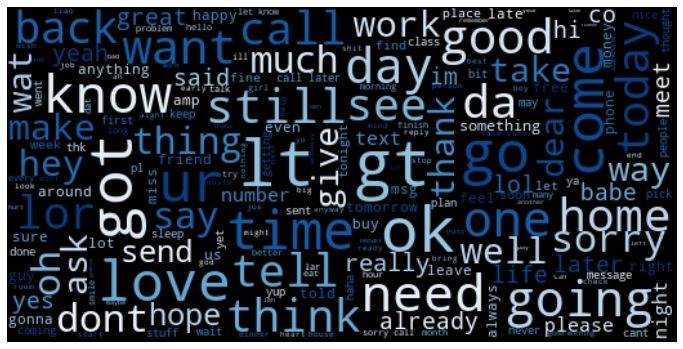

In [ ]:
# wordcloud of ham messages
ham_msg_cloud = WordCloud(
    width = 520, 
    height = 260, 
    stopwords=STOPWORDS,
    max_font_size=50, 
    background_color ="black", 
    colormap='Blues'
).generate(ham_msg_text)
plt.figure(figsize=(12,10))
plt.imshow(ham_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

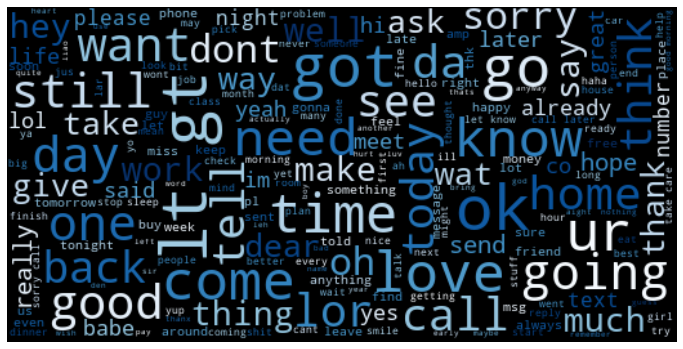

In [ ]:
# wordcloud of spam messages
spam_msg_cloud = WordCloud(
    width = 520, 
    height = 260, 
    stopwords=STOPWORDS,
    max_font_size=50, 
    background_color ="black", 
    colormap='Blues'
).generate(ham_msg_text)
plt.figure(figsize=(12,10))
plt.imshow(spam_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

In [ ]:
ham_msg['Message'] = ham_msg['Message'].apply(tokenizer)
spam_msg['Message'] = spam_msg['Message'].apply(tokenizer)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
ham_msg

,Category,Message
0,ham,"[go, jurong, point, crazy, available, bugis, g..."
1,ham,"[ok, lar, joking, wif, oni]"
3,ham,"[dun, say, early, hor, already, say]"
4,ham,"[nah, think, goes, usf, lives, around, though]"
6,ham,"[even, brother, like, speak, treat, like, aids..."
...,...,...
5565,ham,"[huh, lei]"
5568,ham,"[going, esplanade, fr, home]"
5569,ham,"[pity, mood, suggestions]"
5570,ham,"[guy, bitching, acted, like, interested, buyin..."


In [ ]:
# one way to fix unbalanced data it is to downsample the ham msg
ham_msg_df = ham_msg.sample(n = int(len(spam_msg)*1.1), random_state = 44)
spam_msg_df = spam_msg
print(ham_msg_df.shape, spam_msg_df.shape)

(821, 2) (747, 2)


In [ ]:
# Create a dataframe with these ham and spam msg
final_df = ham_msg_df.append(spam_msg_df).reset_index(drop=True)
final_df

,Category,Message
0,ham,"[height, recycling, read, twice, people, spend..."
1,ham,"[yup, song, bro, creative, neva, test, quality..."
2,ham,"[feb, lt, gt, love, day, send, dis, ur, valued..."
3,ham,"[forget, owns, private, property, good, boy, a..."
4,ham,"[lol, need, cash, nitros, hurry, come, crash]"
...,...,...
1563,spam,"[want, explicit, sex, 30, secs, ring, 02073162..."
1564,spam,"[asked, 3mobile, 0870, chatlines, inclu, free,..."
1565,spam,"[contract, mobile, 11, mnths, latest, motorola..."
1566,spam,"[reminder, o2, get, 50, pounds, free, call, cr..."


In [ ]:
intent2label = {
    intent: label
    for label, intent in enumerate(final_df['Category'].unique())
}

final_df['label'] = final_df['Category'].apply(lambda x: intent2label[x])

In [ ]:
# find the length of the longest message
MAX_LENGTH = final_df['Message'].apply(len).max()
MAX_LENGTH

73

In [ ]:
# split the final Dataframe into train and test
train_df, test_df = train_test_split(final_df, test_size=0.3, random_state=42, shuffle=True)
train_df = train_df.sort_values(by=['label'], ignore_index=True)
test_df = test_df.sort_values(by=['label'], ignore_index=True)

In [ ]:
glove = GloVe(name='6B', dim=50)

.vector_cache/glove.6B.zip: 862MB [02:40, 5.37MB/s]                           
100%|█████████▉| 399999/400000 [00:33<00:00, 12077.59it/s]


In [ ]:
class Dataset:
    def __init__(self, df, max_length=MAX_LENGTH):
        self.df = df
        self.max_length = max_length

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        arr = self.df.loc[idx, 'Message']
        arr = arr + [ '<PAD>' ] * (self.max_length - len(arr))

        return (
            glove.get_vecs_by_tokens(arr), 
            self.df.loc[idx, 'label']
        )

In [ ]:
train_dataset = Dataset(train_df)
test_dataset = Dataset(test_df)

In [ ]:
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
class LSTM(nn.Module):
    #define all the layers used in model
    def __init__(self, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional=True, dropout=0.2):
        #Constructor
        super().__init__()          
        
        # embedding layer
        # self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #lstm layer
        self.lstm = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout,
                           batch_first=True)
        
        #dense layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
    def forward(self, embeds):
        
        #text = [batch size, sent_length]
        # embedded = self.embedding(text)
      
        #embedded = [batch size, sent_len, emb_dim]
        packed_output, (hidden, cell) = self.lstm(embeds)

        #hidden = [batch size, num layers * num directions,hid dim]
        #cell = [batch size, num layers * num directions,hid dim]
        
        #concat the final forward and backward hidden state
        hidden = torch.cat((hidden[-2, : , : ], hidden[-1, : , : ]), dim = 1)
                
        #hidden = [batch size, hid dim * num directions]
        dense_outputs = self.fc(hidden)

        return dense_outputs

In [ ]:
device = torch.device('cuda')
device

device(type='cuda')

In [ ]:
model = LSTM(50, 32, len(intent2label), 2).to(device)

In [ ]:
optimizer = optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

In [ ]:
# Defining the function that contains the training loop
def training_loop(
    n_epochs, optimizer, model, loss_fn,
    train_loader, test_loader, device
):
    # The following torch tensor will hold information about
    # the accuracy results after every epoch
    train_accuracy = torch.zeros(n_epochs)
    test_accuracy = torch.zeros(n_epochs)

    # The actual training_loop
    for epoch in range(n_epochs):
        model.train()
        for examples, labels in train_loader:
            # Copying these tensors to the gpu ram
            # if needed
            # If a cuda compatible gpu is not available
            # the data remains on the cpu ram 
            examples = examples.to(device=device)
            labels = labels.to(device=device)

            outputs = model(examples)
            loss = loss_fn(outputs, labels)

            # Sets the gradients of all optimized torch.Tensor to zero
            optimizer.zero_grad()
            # Back Propagation
            loss.backward()
            # the optimizer updates the parameters
            optimizer.step()
        
        
        # This loop computes the accuracy for test and train data
        # after every epoch
        model.eval()
        for name, loader, accuracy in [
            ('train', train_loader, train_accuracy),
            ('test', test_loader, test_accuracy)
        ]:
            correct = 0
            total = 0

            # This with statement turns off auto grad
            with torch.no_grad():
                for examples, labels in loader:
                    examples = examples.to(device=device)
                    labels = labels.to(device=device)

                    outputs = model(examples)
                    _, predicted = torch.max(outputs, dim=1)
                    
                    total += labels.shape[0]
                    correct += int((predicted == labels).sum())
            
            accuracy[epoch] = correct / total


        # This piece of code saves the models that has the best
        # test accuracy
        best_test_accuracy = (epoch == test_accuracy.max(dim=0)[1].item())
        if best_test_accuracy:
            best_model = copy.deepcopy(model.state_dict())

        print(
            f'Epoch {epoch + 1})', 
            f'Train Accuracy: {train_accuracy[epoch]}',
            f'Test Accuracy: {test_accuracy[epoch]}',
            f'{"Best test accuracy!" if best_test_accuracy else ""}'
        )

    # Plotting the train and test accuracy after every epoch
    plt.figure(dpi=150)
    plt.xlabel('Number of Epochs')
    plt.ylabel('Accuracy')
    plt.plot(range(1, n_epochs + 1), train_accuracy)
    plt.plot(range(1, n_epochs + 1), test_accuracy)
    plt.legend(['Train Accuracy', 'Test Accuracy'])
    plt.grid()
    plt.show()

    return best_model

Epoch 1) Train Accuracy: 0.8678213357925415 Test Accuracy: 0.8386411666870117 Best test accuracy!
Epoch 2) Train Accuracy: 0.9225159287452698 Test Accuracy: 0.9087048768997192 Best test accuracy!
Epoch 3) Train Accuracy: 0.9298085570335388 Test Accuracy: 0.92144376039505 Best test accuracy!
Epoch 4) Train Accuracy: 0.9234275221824646 Test Accuracy: 0.8959660530090332 
Epoch 5) Train Accuracy: 0.951686441898346 Test Accuracy: 0.9299362897872925 Best test accuracy!
Epoch 6) Train Accuracy: 0.9553326964378357 Test Accuracy: 0.9405519962310791 Best test accuracy!
Epoch 7) Train Accuracy: 0.9653600454330444 Test Accuracy: 0.9469214677810669 Best test accuracy!
Epoch 8) Train Accuracy: 0.9671832323074341 Test Accuracy: 0.9447982907295227 
Epoch 9) Train Accuracy: 0.9252507090568542 Test Accuracy: 0.9087048768997192 
Epoch 10) Train Accuracy: 0.976298987865448 Test Accuracy: 0.9554139971733093 Best test accuracy!
Epoch 11) Train Accuracy: 0.9799453020095825 Test Accuracy: 0.9532908797264099 


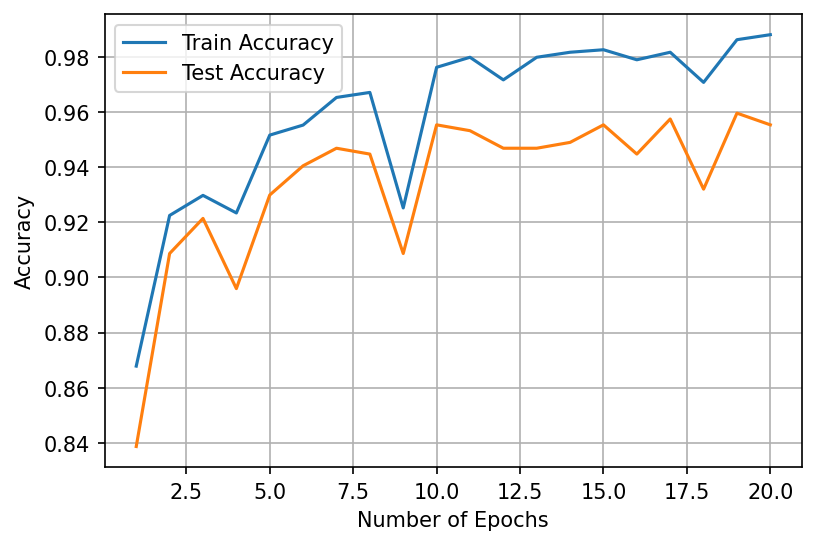

In [ ]:
best_model = training_loop(
    n_epochs=20,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader,
    test_loader=test_loader,
    device=device
)

In [ ]:
# Load the model that had the best test accuracy
model.load_state_dict(best_model)

<All keys matched successfully>

In [ ]:
correct = 0
total = 0

y_test = torch.zeros(len(test_df))
y_pred = torch.zeros(len(test_df))
low = 0

# Make predictions on the test data
model.eval()
with torch.no_grad():
    for examples, labels in test_loader:
        examples = examples.to(device=device)
        labels = labels.to(device=device)

        outputs = model(examples)
        _, predicted = torch.max(outputs, dim=1)

        high = low + labels.shape[0]
        y_test[low : high] = labels
        y_pred[low : high] = predicted
        low = high

        total += labels.shape[0]
        correct += int((predicted == labels).sum())
            
accuracy = correct / total
accuracy

0.9596602972399151

Text(0.5, 32.08333333333333, 'Predicted Label')

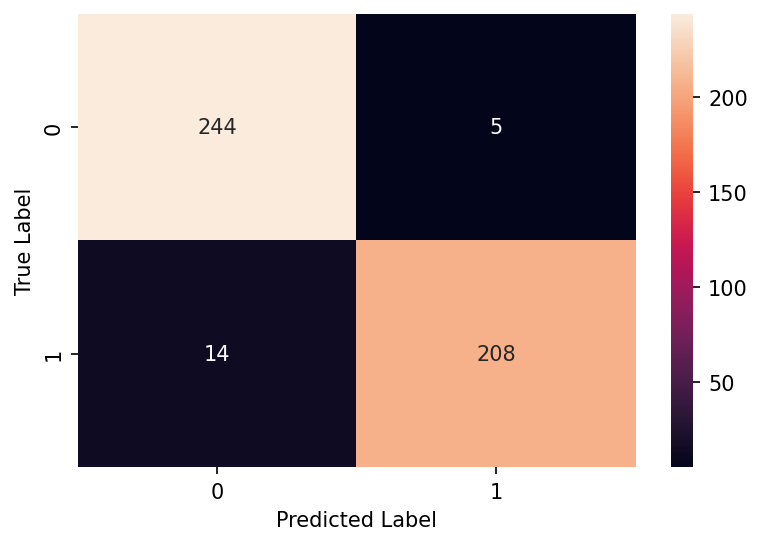

In [ ]:
# Creating a Confusion Matrix plot
plt.figure(dpi=150)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')